In [ ]:
# --- IMPORTS Y CONVENCIÓN DE DATOS ---
# Este bloque importa las librerías necesarias y documenta las expectativas sobre
# los datos de entrada usados a lo largo del notebook.
#
# Convenciones esperadas (usar np.asarray en Fit/Predict convierte entradas):
# - X: array con forma (n_samples, n_features)
# - y: array con forma (n_samples,) conteniendo etiquetas (ints o strings)
# - En modelos que usan regresión logística interna, es recomendable escalar X (StandardScaler).
#
# numpy: operaciones numéricas eficientes y manejo de arrays (vectorizado)
import numpy as np
# BaseEstimator: permite compatibilidad con la API de scikit-learn (metadatos, pipes, etc.)
from sklearn.base import BaseEstimator
# LogisticRegression: implementación probada de regresión logística binaria
from sklearn.linear_model import LogisticRegression

# Nota: las funciones Fit/Predict en las clases definidas esperan entradas array-like
# y las convierten internamente con np.asarray para garantizar compatibilidad.


In [ ]:
# --- ONE-VS-ALL (OvA) - EXPLICACIÓN DETALLADA ---
# One-vs-All (también llamado One-vs-Rest) es una estrategia para convertir
# un problema de clasificación multi-clase en K problemas binarios.
# Idea clave:
#   - Si hay K clases distintas, entrenamos K clasificadores binarios.
#   - El clasificador i se entrena para distinguir "clase i" vs "no clase i".
# En predicción, cada clasificador devuelve una puntuación/probabilidad de "ser la clase i".
# Seleccionamos la clase con mayor puntuación (argmax) como la predicción final.
#
# Ventajas (intuición):
#   - Simple de implementar usando clasificadores binarios probados (ej. LogisticRegression).
#   - Cada clasificador se especializa en reconocer una clase concreta.
# Desventajas / consideraciones:
#   - Se entrenan K modelos (coste lineal en K).
#   - Las probabilidades entre clasificadores pueden no estar calibradas entre sí;
#     comparar directamente predict_proba de clasificadores distintos asume que
#     las salidas son comparables.
#   - Si las clases están muy desbalanceadas, los modelos "vs resto" pueden necesitar
#     ajustes (class_weight, sobremuestreo, etc.).
#
# Formato de datos esperado:
#   - X: array-like convertible a numpy array con forma (n_samples, n_features)
#   - y: array-like convertible a numpy array con forma (n_samples,), etiquetas (ints o strings)
#
# Estrategia de implementación en esta celda:
#   - Guardamos en self.modelos un diccionario que mapea etiqueta -> clasificador binario.
#   - En Fit: para cada etiqueta c creamos y entrenamos un LogisticRegression con y_bin=(y==c).
#   - En Predict: para cada clasificador obtenemos una "puntuación" por muestra.
#       Preferimos predict_proba[:,1] cuando exista (probabilidad de la clase positiva).
#       Si sólo hay decision_function aplicamos una sigmoide para mapear a (0,1).
#       Si no hay probabilidades usamos la predicción dura (0/1) como proxy numérico.
#   - Finalmente apilamos las puntuaciones (muestras x clases) y usamos argmax por fila.
#
# Recomendaciones prácticas:
#   - Escalar (StandardScaler) las columnas de X mejora la estabilidad de los clasificadores lineales.
#   - Para clases desbalanceadas, pasar class_weight='balanced' a LogisticRegression o usar
#     técnicas de re-muestreo.
#   - Para comparar mejor las salidas, calibrar probabilidades con CalibratedClassifierCV si se desea
#     una comparación de probabilidades más fiable entre clasificadores.
#   - Podríamos mejorar Predict sumando probabilidades calibradas o usando decision scores
#     normalizados en lugar de raw predict_proba.
#
class OVAclasificador(BaseEstimator):
    """Wrapper simple que implementa One-vs-All con LogisticRegression.

    Métodos principales:
    - Fit(X, y): entrena K clasificadores binarios.
      Entradas: X np.array (n, d), y np.array (n,)
      Efecto: llena self.modelos y self.clases_. Retorna self.

    - Predict(X): predice etiquetas para m muestras nuevas.
      Entrada: X np.array (m, d)
      Salida: array de etiquetas (m,)
    """

    def __init__(self, C=1.0, solver='lbfgs', max_iter=1000):
        # Parámetros que se pasan a cada LogisticRegression interno
        self.C = C
        self.solver = solver
        self.max_iter = max_iter
        # Diccionario {clase: clasificador_binario}
        self.modelos = {}
        # Etiquetas únicas encontradas en Fit (ordenadas por np.unique)
        self.clases_ = None

    def Fit(self, X, y):
        """Entrena K clasificadores binarios (clase vs resto).

        Entradas:
          - X: array-like (n_samples, n_features)
          - y: array-like (n_samples,)

        Comportamiento:
          - Convierte X,y a numpy arrays.
          - Obtiene etiquetas únicas (self.clases_).
          - Para cada etiqueta construye y_bin = (y == etiqueta).astype(int) y entrena
            un LogisticRegression sobre (X, y_bin).
        """
        X = np.asarray(X)
        y = np.asarray(y)
        # self.clases_ define el orden de las columnas/predicciones posteriores
        self.clases_ = np.unique(y)
        self.modelos = {}

        # Entrenamiento: para cada clase un problema binario
        for clase in self.clases_:
            # y_bin: 1 si la muestra pertenece a 'clase', 0 en caso contrario
            # Shape: (n_samples,)
            y_bin = (y == clase).astype(int)

            # Crear el clasificador binario. Opcional: pasar class_weight='balanced'
            # si hay desbalance severo entre la clase y el resto.
            clf = LogisticRegression(C=self.C, solver=self.solver, max_iter=self.max_iter)

            # Ajuste del modelo binario con todas las características X
            # Nota: si X no está escalado, conviene aplicar StandardScaler antes de Fit
            clf.fit(X, y_bin)

            # Guardar el clasificador para esta etiqueta concreta
            self.modelos[clase] = clf

        return self

    def Predict(self, X):
        """Predice etiquetas para muestras nuevas.

        Proceso:
          1. Para cada clasificador i obtener una puntuación por muestra:
               - preferir predict_proba[:,1] si está disponible (probabilidad de la clase positiva).
               - si existe decision_function, convertir con sigmoide: 1/(1+exp(-df)).
               - si no hay probabilidades, usar predict() (0/1) como puntuación proxy.
          2. Construir matriz P de forma (muestras, K) con puntuaciones por clase.
          3. Para cada muestra elegir la clase que maximiza la puntuación: argmax sobre columnas.

        Devuelve: array de etiquetas (m,)
        """
        X = np.asarray(X)
        if self.clases_ is None:
            raise RuntimeError("El clasificador no está entrenado. Ejecutar Fit primero.")

        puntuaciones = []  # cada elemento será un vector (m,) con puntuaciones para una clase

        for clase in self.clases_:
            clasificador = self.modelos[clase]

            # Si el clasificador soporta predict_proba usamos la probabilidad de la clase positiva
            if hasattr(clasificador, "predict_proba"):
                # predict_proba devuelve (m, 2) para clasificación binaria; columna 1 es P(y=1)
                probs = clasificador.predict_proba(X)[:, 1]
                puntuaciones.append(probs)

            # Si existe decision_function (score en R), aplicamos la sigmoide para obtener (0,1)
            elif hasattr(clasificador, "decision_function"):
                df = clasificador.decision_function(X)
                probs = 1 / (1 + np.exp(-df))  # sigmoide, mapeo a (0,1)
                puntuaciones.append(probs)

            # Si no hay probabilidades, usar la predicción dura (0/1) como proxy numérico
            else:
                preds = clasificador.predict(X)
                puntuaciones.append(preds.astype(float))

        # Apilar las puntuaciones obtenidas por cada clasificador y transponer
        # Resultado: matriz shape (muestras, K) donde columna j corresponde a self.clases_[j]
        puntuaciones = np.vstack(puntuaciones).T

        # Selección final: argmax por fila -> índice de la clase escogida
        indice = np.argmax(puntuaciones, axis=1)

        # Mapear los índices al array de etiquetas reales y devolver
        return self.clases_[indice]


In [ ]:
# --- ONE-VS-ONE (OvO) ---
# Clase que implementa la estrategia One-vs-One: para cada par de clases se entrena
# un clasificador binario usando únicamente las muestras de ese par.
# Ventaja: cada clasificador ve menos ruido entre clases irrelevantes;
# Desventaja: hay K*(K-1)/2 clasificadores, lo que aumenta coste y memoria.
class OVOclasificador(BaseEstimator):
    def __init__(self, C=1.0, solver='lbfgs', max_iter=1000):
        # parámetros pasados a cada regresión logística binaria
        self.C = C
        self.solver = solver
        self.max_iter = max_iter
        # almacenar modelos bajo la clave (clase1, clase2)
        self.modelos = {}
        self.clases_ = None

    # Fit: entrenar un clasificador por cada par de clases
    def Fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.clases_ = np.unique(y)  # etiquetas únicas
        self.modelos = {}

        # Iterar por pares (clase1, clase2) sin repetición
        for i, clase1 in enumerate(self.clases_):
            for clase2 in self.clases_[i + 1:]:
                # seleccionar ejemplos pertenecientes al par (clase1 o clase2)
                mascara = np.logical_or(y == clase1, y == clase2)
                X_par = X[mascara]
                y_par = y[mascara]
                # convertir etiquetas a binarias: 1 -> clase1, 0 -> clase2
                y_bin = np.where(y_par == clase1, 1, 0)

                # entrenar clasificador solo con las muestras del par
                clasificador = LogisticRegression(C=self.C, solver=self.solver, max_iter=self.max_iter)
                clasificador.fit(X_par, y_bin)
                # guardar el modelo con la clave (clase1, clase2)
                self.modelos[(clase1, clase2)] = clasificador

        return self

    # Predict: cada clasificador vota por una de las dos clases; se suma votos y
    # se selecciona la clase con más votos por muestra.
    def Predict(self, X):
        X = np.asarray(X)
        if self.clases_ is None:
            raise RuntimeError("El clasificador no está entrenado. Ejecutar Fit primero.")

        # matriz de votos: filas = muestras, columnas = clases (según orden self.clases_)
        votos = np.zeros((X.shape[0], len(self.clases_)), dtype=int)

        # recorrer cada par y sumar votos en la columna correspondiente
        for (clase1, clase2), clasificador in self.modelos.items():
            preds = clasificador.predict(X)  # 1 significa clase1, 0 significa clase2
            # obtener índice de cada clase en el array self.clases_
            idx1 = int(np.where(self.clases_ == clase1)[0][0])
            idx2 = int(np.where(self.clases_ == clase2)[0][0])

            # asignar votos basados en la predicción binaria
            votos[preds == 1, idx1] += 1
            votos[preds == 0, idx2] += 1

        # la clase con más votos gana; np.argmax devuelve el primer máximo en caso de empate
        indices_pred = np.argmax(votos, axis=1)
        return self.clases_[indices_pred]


In [ ]:
# --- SOFTMAX (Regresión logística multinomial) ---
# Implementación desde cero del clasificador softmax usando descenso por gradiente
# Objetivo: minimizar la pérdida de entropía cruzada (log-loss) con regularización L2
# Ventaja: control total sobre optimización; Desventaja: requiere ajuste de lr/reg y es batch
class SoftmaxRegression(BaseEstimator):

    # Constructor y parámetros importantes:
    # - C/reg: control de regularización (reg es lambda en L2)
    # - lr: learning rate para descenso por gradiente
    # - max_iter: número máximo de iteraciones
    # - tol: tolerancia en la norma del cambio de W para parar
    def __init__(self, C=None, lr=0.1, max_iter=1000, tol=1e-5, reg=None, verbose=False, **kwargs):
        # decidir término de regularización: si se proporciona reg usarlo,
        # si se proporcionó C, usar reg = 1/C para simular interfaz sklearn
        if reg is None:
            if C is None:
                self.reg = 1e-3  # valor por defecto si no se pasa nada
            else:
                self.reg = 1.0 / C
        else:
            self.reg = reg
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        # pesos W con forma (d+1, K) tras Fit (incluye bias en la primera fila)
        self.W = None
        self.classes_ = None

    # Convierte índices de clase (0..K-1) en matriz one-hot (n, K)
    def _one_hot(self, y_idx, K):
        n = y_idx.shape[0]
        Y = np.zeros((n, K))
        Y[np.arange(n), y_idx] = 1
        return Y

    # Fit: entrenamiento por descenso por gradiente (batch)
    # Entradas: X (n, d), y (n,)
    # Salida: self con self.W entrenada y self.classes_ definida
    def Fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        # guardar etiquetas únicas y número de clases K
        self.classes_ = np.unique(y)
        K = len(self.classes_)
        # mapping de clase a índice entero (0..K-1)
        class_to_idx = {c: i for i, c in enumerate(self.classes_)}
        y_idx = np.vectorize(class_to_idx.get)(y)

        n, d = X.shape
        # agregar columna de unos para el bias: Xb (n, d+1)
        Xb = np.hstack([np.ones((n, 1)), X])

        # inicializar pesos a cero; W tiene forma (d+1, K)
        self.W = np.zeros((d + 1, K))

        # matriz de etiquetas one-hot (n, K)
        Y = self._one_hot(y_idx, K)

        # bucle principal de optimización
        for it in range(self.max_iter):
            # scores (n, K) = Xb dot W
            scores = Xb.dot(self.W)
            # mejorar estabilidad numérica restando máximo por fila
            scores -= scores.max(axis=1, keepdims=True)
            exp_scores = np.exp(scores)
            probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)  # softmax

            # gradiente de la pérdida media (entropía cruzada)
            grad = - (Xb.T.dot(Y - probs)) / n
            # regularización L2 (no aplicar al bias: primera fila de W)
            reg_term = self.reg * np.vstack([np.zeros((1, K)), self.W[1:, :]])
            grad += reg_term

            W_old = self.W.copy()
            # actualización de los pesos (descenso por gradiente)
            self.W -= self.lr * grad

            # comprobar convergencia por cambio en la norma de W
            diff = np.linalg.norm(self.W - W_old)
            if self.verbose and (it % 100 == 0 or it == self.max_iter - 1):
                # pérdida + término de regularización para monitorizar
                loss = -np.mean(np.sum(Y * np.log(probs + 1e-15), axis=1)) + 0.5 * self.reg * np.sum(self.W[1:, :] ** 2)
                print(f"it={it} loss={loss:.6f} ||dW||={diff:.6e}")
            if diff < self.tol:
                # criterio de parada por convergencia
                break
        return self

    # Predict: calcula probabilidades por clase y devuelve la etiqueta con mayor probabilidad
    # Entrada: X (m, d) -> salida: etiquetas (m,)
    def Predict(self, X):
        if self.W is None:
            raise RuntimeError("El clasificador no está entrenado. Ejecutar Fit primero.")
        X = np.asarray(X)
        n = X.shape[0]
        Xb = np.hstack([np.ones((n, 1)), X])
        scores = Xb.dot(self.W)
        scores -= scores.max(axis=1, keepdims=True)  # estabilidad numérica
        exp_scores = np.exp(scores)
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]


In [ ]:
# --- BLOQUE DE EVALUACIÓN Y EXPERIMENTO ---
# Este bloque muestra un ejemplo completo: cargar datos, dividir, escalar, entrenar y evaluar.
# Se usa el dataset Iris (3 clases) como ejemplo didáctico.
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Cargar dataset Iris: X shape (150,4), y shape (150,) con 3 clases (0,1,2)
data = load_iris()
X, y = data.data, data.target

# Dividir en entrenamiento y prueba: stratify mantiene la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Escalado: importante para modelos lineales; ajustar scaler solo con entrenamiento
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Instanciar clasificadores. Aquí no se pasan parámetros avanzados por simplicidad
ova = OVAclasificador()
ovo = OVOclasificador()
# Softmax se crea con lr y reg; try/except por compatibilidad con distintas interfaces
try:
    sm = SoftmaxRegression(lr=0.5, max_iter=2000, tol=1e-7, verbose=False, reg=1e-3)
except TypeError:
    sm = SoftmaxRegression(C=1.0, solver='lbfgs', max_iter=2000)

models = [('OvA', ova), ('OvO', novo), ('Softmax', sm)]

results = {}  # diccionario para almacenar métricas y predicciones por modelo

# Entrenar y evaluar cada modelo usando los datos escalados (X_train_s, X_test_s)
for name, model in models:
    t0 = time.time()
    # Fit espera X shape (n, d) y y shape (n,)
    model.Fit(X_train_s, y_train)
    # Predict sobre datos de prueba escalados (m, d)
    y_pred = model.Predict(X_test_s)
    t1 = time.time()
    acc = accuracy_score(y_test, y_pred)
    results[name] = {'accuracy': acc, 'time_s': t1 - t0, 'y_pred': y_pred}
    # Mostrar métricas: accuracy, recall, precision y matriz de confusión por clase
    print(f"{name}: accuracy={acc:.4f} time={t1-t0:.3f}s")
    print(classification_report(y_test, y_pred, target_names=data.target_names))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Resumen final con métricas compactas
print("Resumen:")
for name, info in results.items():
    print(f"{name}: acc={info['accuracy']:.4f} time={info['time_s']:.3f}s")


OvA: accuracy=0.8444 time=0.029s
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      0.73      0.76        15
   virginica       0.75      0.80      0.77        15

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45

Confusion matrix:
 [[15  0  0]
 [ 0 11  4]
 [ 0  3 12]]
------------------------------------------------------------
OvO: accuracy=0.9111 time=0.005s
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45

Confusion matrix:
 [[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]

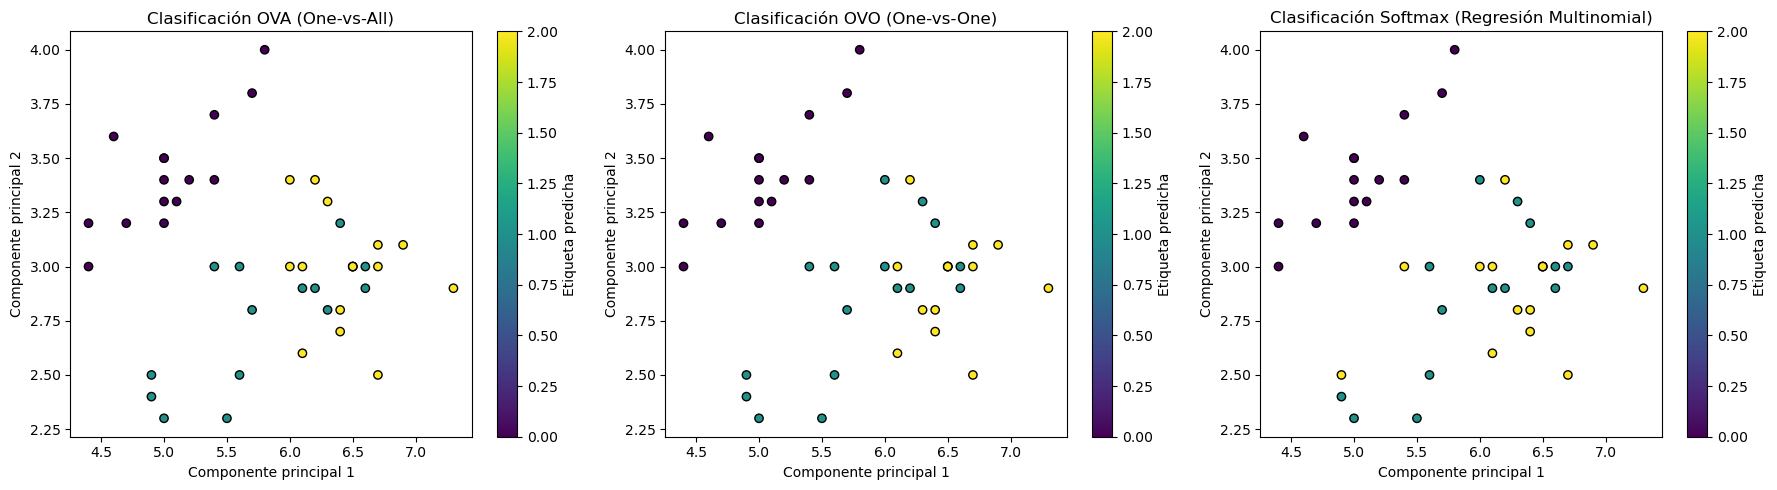

In [ ]:
# --- VISUALIZACIÓN ---
# Mostrar cómo quedan las predicciones en un scatter usando las dos primeras componentes PCA
# Nota importante: para consistencia con la evaluación, usar los mismos datos escalados (X_train_s/X_test_s)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Sugerencia: usar los modelos ya entrenados con los datos escalados.
# Para este bloque vamos a reentrenar con datos escalados y proyectar a 2D via PCA para
# visualización más interpretativa.
modelo_ova = OVAclasificador()
modelo_ovo = OVOclasificador()
modelo_softmax = SoftmaxRegression()

# Reentrenar con datos escalados (si X_train_s/X_test_s existen en el notebook)
try:
    modelo_ova.Fit(X_train_s, y_train)
    modelo_ovo.Fit(X_train_s, y_train)
    modelo_softmax.Fit(X_train_s, y_train)
    # proyectar X_test_s a 2D con PCA para mejor visualización
    pca = PCA(n_components=2)
    X_test_2d = pca.fit_transform(X_test_s)
    y_pred_ova = modelo_ova.Predict(X_test_s)
    y_pred_ovo = modelo_ovo.Predict(X_test_s)
    y_pred_softmax = modelo_softmax.Predict(X_test_s)
except NameError:
    # si no existen las versiones escaladas, fallback a datos sin escalar (menos recomendado)
    modelo_ova.Fit(X_train, y_train)
    modelo_ovo.Fit(X_train, y_train)
    modelo_softmax.Fit(X_train, y_train)
    pca = PCA(n_components=2)
    X_test_2d = pca.fit_transform(X_test)
    y_pred_ova = modelo_ova.Predict(X_test)
    y_pred_ovo = modelo_ovo.Predict(X_test)
    y_pred_softmax = modelo_softmax.Predict(X_test)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred_ova, cmap='viridis', edgecolor='k')
plt.title('Clasificación OVA (One-vs-All)')
plt.xlabel('Componente 1 (PCA)')
plt.ylabel('Componente 2 (PCA)')
plt.colorbar(label='Etiqueta predicha')

plt.subplot(1, 3, 2)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred_ovo, cmap='viridis', edgecolor='k')
plt.title('Clasificación OVO (One-vs-One)')
plt.xlabel('Componente 1 (PCA)')
plt.ylabel('Componente 2 (PCA)')
plt.colorbar(label='Etiqueta predicha')

plt.subplot(1, 3, 3)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred_softmax, cmap='viridis', edgecolor='k')
plt.title('Clasificación Softmax (Regresión Multinomial)')
plt.xlabel('Componente 1 (PCA)')
plt.ylabel('Componente 2 (PCA)')
plt.colorbar(label='Etiqueta predicha')

plt.tight_layout()
plt.show()
